<a href="https://colab.research.google.com/github/Rad-Monk/Code/blob/main/Multiclass_classification_Stack_Overflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import tensorflow as tf
import string
from tensorflow.keras import layers
from tensorflow.keras import losses

In [ ]:
#shutil.rmtree('/content/stack_overflow')

In [ ]:
os.mkdir('stack_overflow')

url = "https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"

dataset = tf.keras.utils.get_file("stack_overflow_16k", url,
                                    untar=True, cache_dir='/content/stack_overflow',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), '')

* untar -> used to tell if the data needs to be extracted from a tar file
* cache_dir -> used to tell where to store the cache dir, for it indicates current working directory by '.'.
* cacher_subdir -> used to set a subdir inside main dir, useful for putting multiple datasets in a single directory, in our case it's just stored in root
* os = path join is used to a construct a path to directory stack_overflow, the path.dirname gets the path of the dataset

In [ ]:
os.listdir(dataset_dir)

In [ ]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

In [ ]:
test_dir = os.path.join(dataset_dir, 'test')

In [ ]:
sample = os.path.join(train_dir, 'java/0.txt')
with open(sample) as f:
  print(f.read())

In [ ]:
batch_size = 36
seed = 13

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir,
    seed = seed,
    batch_size = batch_size,
    validation_split = .2,
    subset = 'training'
)

In [ ]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    test_dir,
    batch_size = batch_size
)

In [ ]:
raw_validation_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir,
    seed = seed,
    batch_size = batch_size,
    validation_split = .2,
    subset = 'validation'
)

In [ ]:
for text, label in raw_train_ds.take(1):
  for j in range(36):
    print(text.numpy()[j])
    print(label.numpy()[j])

In [ ]:
raw_train_ds.class_names[3]

In [ ]:
def custom_standadizer(text):
  lowercase_text = tf.strings.lower(text)
  stripped_html = tf.strings.regex_replace(lowercase_text,'<br />',' ')
  stripped_punctuation = tf.strings.regex_replace(stripped_html, '[%s]' % re.escape(string.punctuation),'')
  return stripped_punctuation

In [ ]:
for text,label in raw_train_ds.take(1):
  for j in range(3):
    print(len(text.numpy()[j]))

In [ ]:
raw_train_ds.cardinality()

In [ ]:
word_count = 0
elements = 0
for batch in raw_train_ds:
  for element in batch:
    for x in element:
      word_count += len(str(x).split())
    elements += 1

avg_word_count = word_count//elements

In [ ]:
print(avg_word_count)

In [ ]:
max_features = 6000
sequence_length = 200

vectorizer = layers.TextVectorization(
    standardize = custom_standadizer,
    max_tokens = max_features,
    output_sequence_length = sequence_length,
    output_mode = 'int'
)

In [ ]:
train_text = raw_train_ds.map(lambda x,y: x)
vectorizer.adapt(train_text)

In [ ]:
def vectorize_text(text,label):
  text = tf.expand_dims(text,-1)
  return vectorizer(text), label


In [ ]:
train_ds = raw_train_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)
val_ds = raw_validation_ds.map(vectorize_text)

In [ ]:
autotune = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = autotune)
test_ds = test_ds.cache().prefetch(buffer_size = autotune)
val_ds = val_ds.cache().prefetch(buffer_size = autotune)

In [ ]:
embedding_dim = 16

In [ ]:
model = tf.keras.Sequential([
    layers.Embedding(max_features, embedding_dim),
    layers.Dropout(.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(.2),
    layers.Dense(4,activation = 'sigmoid')]
)

model.summary()

In [ ]:
loss = losses.SparseCategoricalCrossentropy(from_logits= True)

In [ ]:
optimiser = 'adam'

In [ ]:
model.compile(
    loss= loss,
    optimizer = optimiser,
    metrics = ['accuracy']
)

In [ ]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = epochs
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


178/178 [==============================] - 24s 120ms/step - loss: 1.3782 - accuracy: 0.3862 - val_loss: 1.3661 - val_accuracy: 0.4363
Epoch 2/10
178/178 [==============================] - 1s 4ms/step - loss: 1.3439 - accuracy: 0.4894 - val_loss: 1.3224 - val_accuracy: 0.4881
Epoch 3/10
178/178 [==============================] - 1s 4ms/step - loss: 1.2864 - accuracy: 0.5548 - val_loss: 1.2581 - val_accuracy: 0.5462
Epoch 4/10
178/178 [==============================] - 1s 4ms/step - loss: 1.2117 - accuracy: 0.5947 - val_loss: 1.1851 - val_accuracy: 0.5863
Epoch 5/10
178/178 [==============================] - 1s 4ms/step - loss: 1.1322 - accuracy: 0.6409 - val_loss: 1.1139 - val_accuracy: 0.6363
Epoch 6/10
178/178 [==============================] - 1s 6ms/step - loss: 1.0553 - accuracy: 0.6786 - val_loss: 1.0484 - val_accuracy: 0.6625
Epoch 7/10
178/178 [==============================] - 1s 6ms/step - loss: 0.9858 - accuracy: 0.7089 - val_loss: 0.9907 - val_accuracy: 0.6862
Epoch 8/10
178

In [ ]:
loss, accuracy = model.evaluate(test_ds)
print(loss, accuracy)

223/223 [==============================] - 1s 4ms/step - loss: 0.8536 - accuracy: 0.7318
0.8536015748977661 0.7317500114440918


In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

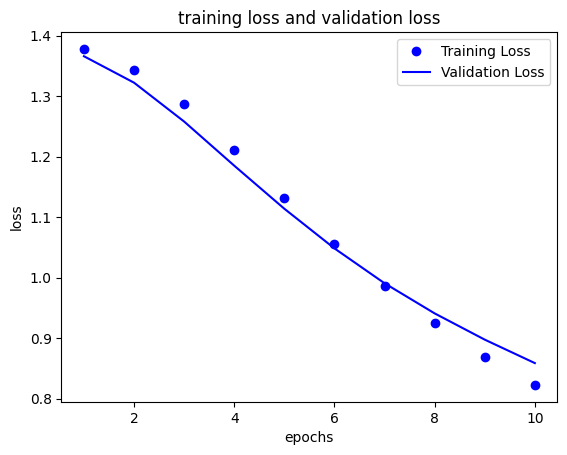

In [ ]:
acc= history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, loss, 'bo', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('training loss and validation loss')
plt.legend()
plt.show()

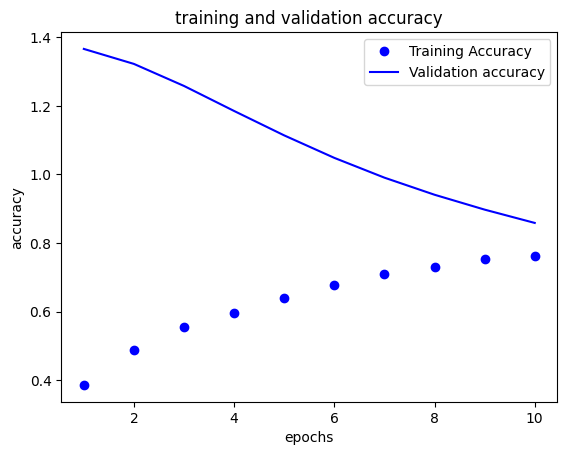

In [ ]:
plt.plot(epochs, acc, 'bo', label = 'Training Accuracy')
plt.plot(epochs, val_loss, 'b', label = 'Validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('training and validation accuracy')
plt.legend()
plt.show()

In [ ]:
export_model = tf.keras.Sequential(
    [vectorizer,
    model,
    layers.Activation('sigmoid')]
)

export_model.compile(loss= loss, optimizer = optimiser, metrics = ['accuracy'])

